In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd

In [51]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [53]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [58]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [59]:
# Create our session (link) from Python to the DB
session = Session(engine)
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [60]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date_str = session.query(func.max(Measurement.date)).scalar() #pull date string 
(Y,M,D) = date_str.split('-')
(Y,M,D) = int(Y),int(M),int(D)
query_date = dt.date(Y, M, D) - dt.timedelta(days=365) # subtract a year from last date

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
temperature = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > last_year).\
        order_by(Measurement.date).all()
    
temperature

[('2016-08-24', 79.0),
 ('2016-08-24', 76.0),
 ('2016-08-24', 80.0),
 ('2016-08-24', 78.0),
 ('2016-08-24', 79.0),
 ('2016-08-24', 77.0),
 ('2016-08-24', 74.0),
 ('2016-08-25', 80.0),
 ('2016-08-25', 77.0),
 ('2016-08-25', 81.0),
 ('2016-08-25', 81.0),
 ('2016-08-25', 80.0),
 ('2016-08-25', 80.0),
 ('2016-08-25', 77.0),
 ('2016-08-26', 79.0),
 ('2016-08-26', 78.0),
 ('2016-08-26', 81.0),
 ('2016-08-26', 81.0),
 ('2016-08-26', 84.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 77.0),
 ('2016-08-27', 73.0),
 ('2016-08-27', 81.0),
 ('2016-08-27', 81.0),
 ('2016-08-27', 75.0),
 ('2016-08-27', 74.0),
 ('2016-08-28', 78.0),
 ('2016-08-28', 73.0),
 ('2016-08-28', 81.0),
 ('2016-08-28', 80.0),
 ('2016-08-28', 73.0),
 ('2016-08-28', 71.0),
 ('2016-08-29', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-29', 80.0),
 ('2016-08-29', 80.0),
 ('2016-08-29', 79.0),
 ('2016-08-29', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-30', 76.0),
 ('2016-08-30', 79.0),
 ('2016-08-30', 78.0),
 ('2016-08-

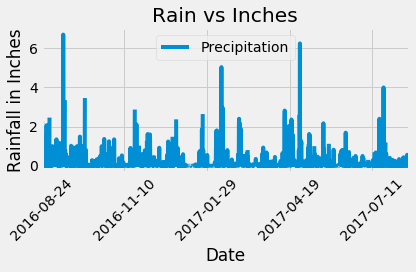

In [62]:
# Perform a query to retrieve the data and precipitation scores

date_str = str(query_date)
session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_str).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_str).all()
date_prcp_df = pd.DataFrame(date_prcp)
date_prcp_df = date_prcp_df.rename(columns={"prcp":"precipitation"})
#date_prcp_df = date_prcp_df.dropna()
date_prcp_df = date_prcp_df.sort_values(by=['date'])

date_prcp_df.set_index('date').head()

date_prcp_df.plot('date', 'precipitation')
plt.xlabel("Date")
plt.ylabel("Rainfall in Inches")
plt.title("Rain vs Inches")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [64]:
# Design a query to show how many stations are available in this dataset?
query = session.query(Measurement.station).\
    distinct().\
    all()
len(query)

#engine.execute('SELECT distinct count(station) from station').fetchall()



9

In [65]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#len(engine.execute('SELECT distinct station from measurement').fetchall())
#query2 = engine.execute('SELECT station, count(prcp) from measurement group by station order by count(prcp) desc').fetchall()

top_station = session.query(Measurement.station,func.count(Measurement.prcp)).\
                group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

station_id = top_station[0][0]


In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# func.min, func.max, func.avg, and func.count

session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).\
    group_by(Measurement.station).all()



[('USC00519281', 54.0, 85.0, 85.0, 71.66378066378067)]

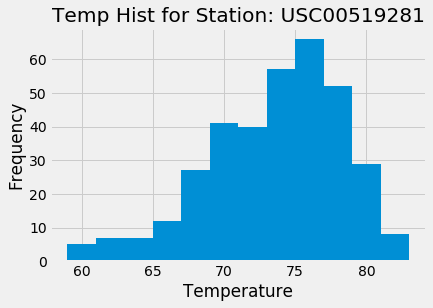

In [67]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# what about dropna for these values?  Should it be the same as above with prcpf

# calculate highest temprature observations
highest = session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
hstation = highest[0][0]

# get dataframe for freq vs temp hist
stmt = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
            filter(Measurement.date > date_str).\
            filter(Measurement.station == hstation).\
            order_by(Measurement.date).statement

temp_hist_df = pd.read_sql_query(stmt, session.bind)

temp_hist_df
plt.hist(temp_hist_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temp Hist for Station: " + hstation)
plt.show()
#hstation

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
date1 = dt.date(2011, 2, 28)
date2 = dt.date(2011, 3, 5)

temp_range = calc_temps(date1, date2)
temp_range


[(61.0, 69.75510204081633, 75.0)]

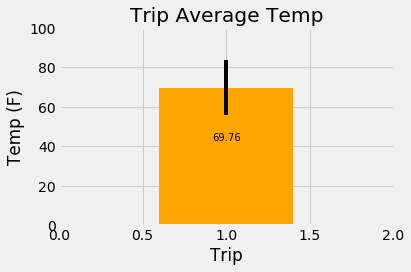

In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

delta = temp_range[0][2]-temp_range[0][0]
min_temp = temp_range[0][0]
avg_temp = temp_range[0][1]
max_temp = temp_range[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avg_temp, color= 'orange', yerr=delta)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Average Temp")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()


In [91]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

date1 = dt.date(2015, 2, 28)
date2 = dt.date(2015, 3, 5)

# Query database for temperatures between start and end date
prcp_by_station = session.query(Measurement.station,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= date2).\
            group_by(Measurement.station).all()
    
# Convert results to dataframe
prcp_by_station_df = pd.DataFrame(prcp_by_station, columns=['station', 'prcp','latitude','longitude','elevation'])

# Display results
prcp_by_station_df



,station,prcp,latitude,longitude,elevation
0,USC00511918,21.31520,-157.99920,0.9,4.81
1,USC00513117,21.42340,-157.80150,14.6,133.88
2,USC00514830,21.52130,-157.83740,7.0,87.45
3,USC00516128,21.33310,-157.80250,152.4,393.87
4,USC00517948,21.39340,-157.97510,11.9,9.69
5,USC00518838,21.49920,-158.01110,306.6,0.00
6,USC00519281,21.45167,-157.84889,32.9,202.71
7,USC00519397,21.27160,-157.81680,3.0,42.90
8,USC00519523,21.33556,-157.71139,19.5,108.96


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
